In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import json

df_train = pd.read_csv('train_data.csv')
df_val = pd.read_csv('val_data.csv')
df_test = pd.read_csv('test_data.csv')

with open('label_mapping.json', 'r') as f:
    label_mapping = json.load(f)

label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(list(label_mapping.keys()))

In [ ]:
df_train.head(2)

,document,press_encoded
0,서울 황기선 기자 5일 서울 중구 하나은행 위변조대응센터에서 직원이 달러를 정리하고...,0
1,기사내용 요약 무역적자·경기침체 영향 마이크론發 반도체 투심 악화…삼전 매물 쏟아져...,1


In [ ]:
!pip install pyLDAvis konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 35.4 MB/s eta 0:00:00


In [ ]:
import konlpy
from konlpy.tag import Okt
import requests

stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ko/master/stopwords-ko.txt"
korean_stopwords = requests.get(stopwords_url).text.split('\n')
korean_stopwords = set([word.strip() for word in korean_stopwords if word.strip()])

okt = Okt()

def tokenizer(text):
    tokens = okt.morphs(text)
    words = [word.lower() for word in tokens if word not in korean_stopwords and len(word) > 2]
    return words

In [ ]:
from tqdm import tqdm

texts_train = [tokenizer(news) for news in tqdm(df_train['document'], desc="Tokenizing Train Data")]
texts_val = [tokenizer(news) for news in tqdm(df_val['document'], desc="Tokenizing Val Data")]
texts_test = [tokenizer(news) for news in tqdm(df_test['document'], desc="Tokenizing Test Data")]

Tokenizing Test Data: 100%|██████████| 1440/1440 [00:55<00:00, 25.80it/s]


In [ ]:
texts = texts_train+texts_val

In [ ]:
from gensim.corpora.dictionary import Dictionary

dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

dictionary.filter_extremes(keep_n=2000, no_below=5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 39193
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 8156


In [ ]:
corpus[1000]

[(14, 1),
 (31, 1),
 (46, 1),
 (47, 1),
 (48, 3),
 (49, 2),
 (227, 1),
 (258, 1),
 (1453, 1),
 (1498, 1),
 (1499, 1),
 (1500, 1),
 (1501, 1),
 (1502, 1)]

In [ ]:
from gensim.models import LdaModel

num_topics = 10
passes = 10
model = LdaModel(corpus=corpus, id2word=dictionary, passes=passes, num_topics=num_topics)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.068543  0.194282       1        1  17.143995
4      0.163798 -0.098338       2        1  14.640711
8      0.145660  0.005330       3        1  11.160875
9      0.054211  0.056462       4        1  10.174947
7     -0.192295  0.178351       5        1   9.856296
2      0.183404 -0.167988       6        1   9.747159
6      0.064276  0.104787       7        1   8.018289
3     -0.040149  0.095653       8        1   6.952189
0      0.071012 -0.116610       9        1   6.533491
1     -0.381374 -0.251927      10        1   5.772047, topic_info=    Term         Freq        Total Category  logprob  loglift
27   com  1619.000000  1619.000000  Default  30.0000  30.0000
74   서비스  3611.000000  3611.000000  Default  29.0000  29.0000
328  카카오  1631.000000  1631.000000  Default  28.0000  28.0000
138  플랫폼  2096.000000  2096.000000  Default  27.0000  27.0000
623  브랜드  1335.000000  1335.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
349  강남구   133.342246   228.080424  Topic10  -4.8150   2.3154
49   포인트   365.905997  1539.630180  Topic10  -3.8055   1.4152
227  마쳤다   102.504854   394.768873  Topic10  -5.0780   1.5038
10   따르면   132.115053  2367.068031  Topic10  -4.8242  -0.0336
8    글로벌    91.033589  2301.694304  Topic10  -5.1966  -0.3780

[636 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1580      5  0.983856  0.25%
17        5  0.987132   0.4%
824       5  0.987020   1.5%
474       5  0.978558   1.6%
1498     10  0.993110  1.80%
...     ...       ...    ...
532       5  0.032502    휘발유
532       8  0.198626    휘발유
532       9  0.552541    휘발유
532      10  0.213071    휘발유
1703      2  0.981402  힐스테이트

[1179 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 9, 10, 8, 3, 7, 4, 1, 2])

In [ ]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-4.172871210562294


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num_topics: 6, perplexity: -6.708, coherence: -3.660


num_topics: 7, perplexity: -6.691, coherence: -3.813


num_topics: 8, perplexity: -6.675, coherence: -4.212


num_topics: 9, perplexity: -6.666, coherence: -4.123


num_topics: 10, perplexity: -6.639, coherence: -4.239


num_topics: 11, perplexity: -6.602, coherence: -4.316


num_topics: 12, perplexity: -6.590, coherence: -4.514


num_topics: 13, perplexity: -6.592, coherence: -4.508


num_topics: 14, perplexity: -6.580, coherence: -4.885
num_topics: 15, perplexity: -6.572, coherence: -4.526


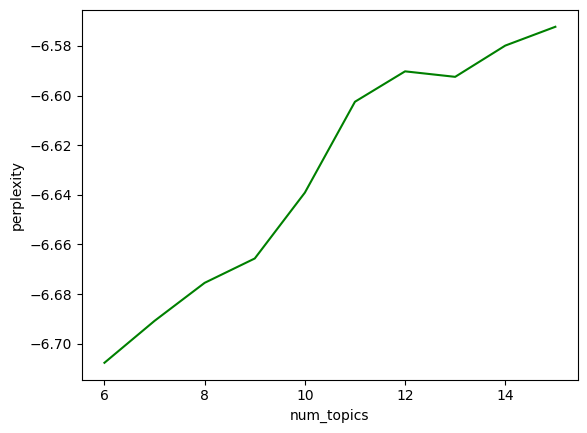

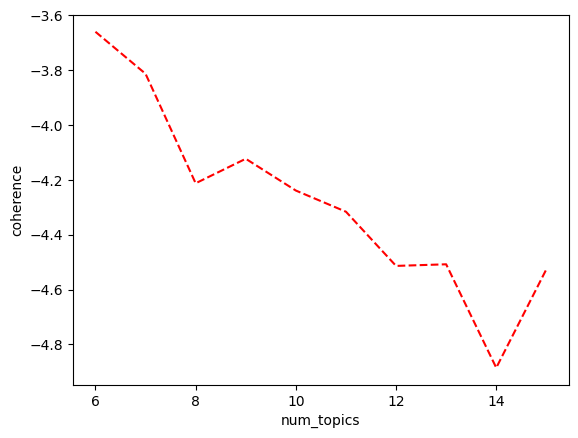

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=i, random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)

        cm = CoherenceModel(model=model, corpus=corpus,
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=6, end=15)

In [ ]:
def get_topic_distribution(model, corpus, num_topics):
    topic_distributions = []
    for doc_bow in corpus:
        doc_topics = model.get_document_topics(doc_bow, minimum_probability=0.0)
        doc_topics = [prob for _, prob in sorted(doc_topics, key=lambda x: x[0])]
        topic_distributions.append(doc_topics)
    return topic_distributions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_distributions = get_topic_distribution(model, corpus, num_topics)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_distributions[1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.0016397587,
 0.101011224,
 0.0016398047,
 0.0016397613,
 0.0016397772,
 0.16890706,
 0.0016397825,
 0.71860296,
 0.0016397681,
 0.0016400812]

In [ ]:
len(topic_distributions[:len(df_train)])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6717

In [ ]:
train_df = pd.DataFrame({'document':df_train['document'], 'topic_distribution':topic_distributions[:len(df_train)],	'press_encoded':df_train['press_encoded']})
val_df = pd.DataFrame({'document':df_val['document'], 'topic_distribution':topic_distributions[len(df_train):],	'press_encoded':df_val['press_encoded']})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def test_topic_distribution(model, dictionary, texts):
    corpus = [dictionary.doc2bow(token) for token in texts]
    topic_distributions = []
    for doc_bow in corpus:
        doc_topics = model.get_document_topics(doc_bow, minimum_probability=0.0)
        doc_topics = [prob for _, prob in sorted(doc_topics, key=lambda x: x[0])]
        topic_distributions.append(doc_topics)
    return topic_distributions

test_topic_distributions = test_topic_distribution(model, dictionary, texts_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
test_df = pd.DataFrame({'document':df_test['document'], 'topic_distribution':test_topic_distributions,	'press_encoded':df_test['press_encoded']})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_df['topic_distribution'] = train_df['topic_distribution'].apply(lambda x: ','.join(map(str, x)))
val_df['topic_distribution'] = val_df['topic_distribution'].apply(lambda x: ','.join(map(str, x)))
test_df['topic_distribution'] = test_df['topic_distribution'].apply(lambda x: ','.join(map(str, x)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,document,topic_distribution,press_encoded
0,서울 황기선 기자 5일 서울 중구 하나은행 위변조대응센터에서 직원이 달러를 정리하고...,"0.005263677,0.005266065,0.0052636317,0.0052637...",0
1,기사내용 요약 무역적자·경기침체 영향 마이크론發 반도체 투심 악화…삼전 매물 쏟아져...,"0.0016397587,0.101011224,0.0016398047,0.001639...",1
2,서울 김근수기자 비트코인이 경기 침체와 고금리에 대한 우려로 가상화폐 가격이 등락을...,"0.005555715,0.949997,0.0055557163,0.0055557205...",1
3,국제 에어쇼 참가 T 50B 항공기 9대 원주→영국 운송 완료 분해·운송·재조립 최...,"0.0024399012,0.00243986,0.06396428,0.002439780...",0
4,서울 강민지 기자 고유가 상황에서 화물차·버스·택시업계의 유류비 부담을 줄여주기 위...,"0.36665455,0.033340983,0.033344693,0.033346143...",2
...,...,...,...
6712,기사내용 요약 코로나 기간 마이너스 대출 수혜…ECB 이사회 소집해 논의 서울 이종...,"0.0026323083,0.002632279,0.0026326545,0.034806...",1
6713,평양 노동신문 북한 노동당 기관지 노동신문은 5일 연포온실농장 건설 현장에서 자기 ...,"0.016670156,0.016670156,0.016670156,0.01667015...",0
6714,서울 갤러리아백화점이 명품관에서 국내산 햇사과 썸머킹 을 올해 처음 선보인다고 3일...,"0.21422124,0.025001077,0.58575714,0.025002025,...",2
6715,기사내용 요약 어촌어항공단·자이언트펭tv 협업… 안전문화 확산 서울 펭수·가수 KC...,"0.005265684,0.005265845,0.6224153,0.0052653817...",1


In [ ]:
val_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,document,topic_distribution,press_encoded
0,이동석 대표이사 미래 생존ㆍ고용안정 방안 찾자 현대차 노사 교섭 대표들 자료사진 울...,"0.0030309903,0.0030309295,0.0030309092,0.00303...",2
1,기사내용 요약 블랙이글스 T 50B 항공기 9대 국제 에어쇼 참가 특수화물 장비 투...,"0.03785051,0.10587746,0.0014712414,0.001470985...",1
2,서울 이종호 과학기술정보통신부 장관이 5일 오후 경기도 성남시 수정구 메타버스허브에...,"0.01000111,0.010000647,0.0100006685,0.01000064...",2
3,호반그룹 창립 33주년 기념식 호반그룹 제공 서울 홍국기 기자 호반그룹은 창립 33...,"0.0058851475,0.0058838846,0.3163103,0.00588783...",2
4,서울 백동현 기자 실거주 목적의 전입신고를 했다면 재개발 사업이 진행 중인 지역이라...,"0.004000251,0.96399724,0.004000139,0.00400029,...",1
...,...,...,...
1434,고양 추상철 기자 2022 국제안전보건전시회가 열린 4일 오전 경기 고양시 킨텍스 ...,"0.3227096,0.6409245,0.0045460286,0.004545646,0...",1
1435,서울 이광호 기자 국내 소비자물가 상승률이 IMF 외환위기 이후 약 24년 만에 6...,"0.0027030592,0.002702958,0.0027029146,0.948396...",0
1436,서울 임세영 기자 3일 서울 영등포구 여의도 더현대서울에서 열린 월리 행복 걷기 챌...,"0.009092648,0.00909199,0.5552211,0.0090916995,...",0
1437,양주 우영식 기자 경기 양주시는 전국 최초로 섬유류 폐기물 전용 종량제봉투 를 제작...,"0.006668653,0.006667245,0.006668586,0.06810401...",2


In [ ]:
test_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,document,topic_distribution,press_encoded
0,서울 이재희 기자 롯데면세점은 지난달 내국인 매출이 지난해 같은 기간보다 약 260...,"0.010002271,0.010000677,0.52971023,0.010002525...",2
1,부산 하경민 기자 에너지·원자재 가격 상승으로 상반기 1 6월 무역수지가 역대 최대...,"0.0045464085,0.5822072,0.0045467163,0.00454622...",1
2,호텔 카지노 리테일 부문 전년 대비 2배 성장 성수기 국제관광 재개로 3분기 괄목할...,"0.18809037,0.0018524312,0.06556601,0.001852761...",0
3,1분기 KB주택구입잠재력지수 전년비 반토막 역대최저 매매가격지수 상승폭보다 주담대 ...,"0.002084702,0.002084143,0.0020840701,0.0020842...",0
4,SSG닷컴이 서울 강남권역으로 본사 이전을 완료했다. SSG닷컴은 자회사인 W컨셉과...,"0.0015883602,0.001588365,0.3893206,0.001588995...",4
...,...,...,...
1435,서울 아이트로닉스. 사진 DB . photo .com 서울 배민욱 기자 4일 중소기...,"0.12239765,0.01890204,0.28953534,0.01807826,0....",1
1436,서울 강세훈 기자 올 하반기 서울과 인접한 이른바 서울 옆세권 지역에서 아파트 단지...,"0.038436517,0.0024399878,0.0024396966,0.002440...",1
1437,취임사 하는 김기웅 제47대 서천군수 서천군 제공. 재판매 및 DB 금지 서천 조성...,"0.0071449084,0.007144551,0.007146059,0.0071451...",2
1438,서울 조재호 농촌진흥청장이 4일 전남 무안 국립식량과학원 바이오에너지작물연구소를 방...,"0.02000065,0.020000635,0.020000739,0.020001216...",2


In [ ]:
train_df.to_csv('LDA_train_df.csv', index = False)
val_df.to_csv('LDA_val_df.csv', index = False)
test_df.to_csv('LDA_test_df.csv', index = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
